<a href="https://colab.research.google.com/github/sspaulc/TED_TALKS_VIEWS_PREDICTION/blob/main/Ted_Talk_Views_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement-- TED is devoted to spreading powerful ideas on just about any topic. These datasets contain over 4,000 TED talks including transcripts in many languages. Founded in 1984 by Richard Salman as a nonprofit organization that aimed at bringing experts from the fields of Technology, Entertainment, and Design together, TED Conferences have gone on to become the Mecca of ideas from virtually all walks of life. As of 2015, TED and its sister TEDx chapters have published more than 2000 talks for free consumption by the masses and its speaker list boasts of the likes of Al Gore, Jimmy Wales, Shahrukh Khan, and Bill Gates. The main objective is to build a predictive model, which could help in predicting the views of the videos uploaded on the TEDx website

# Importing Libraires:


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn import ensemble

import warnings
warnings.filterwarnings('ignore')

In [2]:
from wordcloud import WordCloud,ImageColorGenerator

# Collecting data:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
#Read the data

data= pd.read_csv("/content/gdrive/MyDrive/AlmaBetter/Almabetter/Capstone Projects/Ted Talk Views Prediction/data_ted_talks.csv")


In [5]:
data.columns

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description', 'transcript'],
      dtype='object')

# **Exploratory Data Analysis:**

#Hypotheses:

1. Events with more counts will have more views

2. Medium Duration of videos have most views

3. Most popular speakers like Alex Gendler will have more views

4. Number of languages it is available in will have more views.

5. Occupations like 'Activist' will have most views.

6. Topics like 'Technology' will have most views.

7. Older videos will have more views.

8. More comments will have more views.

9. More number of tags will have more views.

10. Videos published on Fridays will have more views.

##**1. Events:**

In [6]:
len(data['event'].unique())

459

There are 459 unique values for events. Let us rectify that first. Every event that has occurred in the same year will be considered in the same bin.

In [7]:
# initialise all values as 'Other' to assign this category
# to all entries that don't fit into the chosen categories
data['event_category'] = 'Other'

for i in range(len(data)):
    if data['event'][i][0:5]=='TED20':
        data['event_category'][i] = 'TED2000s'
    elif data['event'][i][0:5]=='TED19':
        data['event_category'][i] = 'TED1900s'
    elif data['event'][i][0:4]=='TEDx':
        data['event_category'][i] = "TEDx"
    elif data['event'][i][0:7]=='TED@BCG':
        data['event_category'][i] = 'TED@BCG'
    elif data['event'][i][0:4]=='TED@':
        data['event_category'][i] = "TED@"
    elif data['event'][i][0:8]=='TEDSalon':
        data['event_category'][i] = "TEDSalon"
    elif data['event'][i][0:9]=='TEDGlobal':
        data['event_category'][i] = 'TEDGlobal'
    elif data['event'][i][0:8]=='TEDWomen':
        data['event_category'][i] = 'TEDWomen'
    elif data['event'][i][0:6]=='TEDMED':
        data['event_category'][i] = 'TEDMED'
    elif data['event'][i][0:3]=='TED':
        data['event_category'][i] = 'TEDOther'

Let us see the Event with most counts:

Text(0.5, 1.0, 'Event Count')

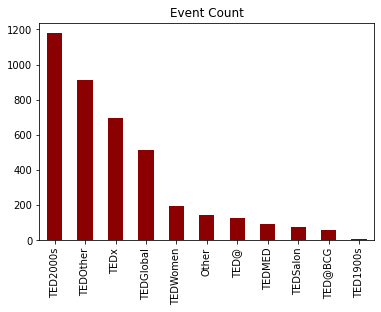

In [8]:
data['event_category'].value_counts().sort_values(ascending=False).plot(kind='bar',color='darkred')

plt.title('Event Count')

According to this data, TED2000s should have most views as they were most in count.

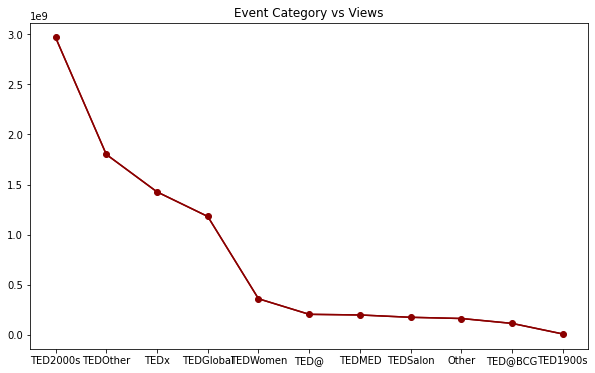

In [9]:
#Event with actual views
plt.figure(figsize=(10,6))

plt.plot(data[['event_category','views']].groupby('event_category').agg({'views':'sum'})['views'].sort_values(ascending=False),color='darkred')

plt.title('Event Category vs Views')

plt.plot(data[['event_category','views']].groupby('event_category').agg({'views':'sum'})['views'].sort_values(ascending=False),marker='o',color='darkred')

First hypothesis is true.

## **2. Duration:**

Text(0.5, 1.0, 'Duration vs Views')

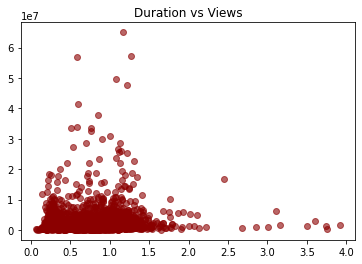

In [10]:
plt.scatter(x= data['duration']/1000,y=data['views'],color='darkred',alpha=0.6)

plt.title('Duration vs Views')

Most vidoes with lesser duration are more closely related to views.

## **3. Speakers:**

In [11]:
data['speaker_1'][0]

'Al Gore'

In [12]:
speakers=data.groupby('speaker_1').agg({'views':'sum'})['views']

In [13]:
speakers= speakers.sort_values(ascending= False)

In [14]:
speakers=speakers.head(10)

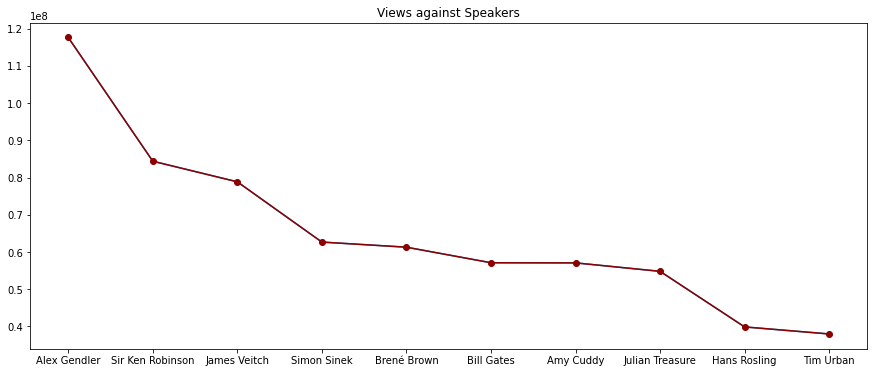

In [15]:
#Plotting the graph

plt.figure(figsize=(15,6))

plt.plot(speakers)

plt.title('Views against Speakers')

plt.plot(speakers,marker='o',color='darkred')

Alex Gendler is one of the most popular guests on Ted Talks and thus he has the highest number of views. 

And thus my hypothesis was correct.

One of his best videos being Building the Brooklyn bridge. 

Let us see if it is true.



In [16]:
data[data['views']== data['views'].max()]

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript,event_category
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,en,"['af', 'ar', 'az', 'be', 'bg', 'bn', 'ca', 'cs...",4931.0,1164,"['children', 'creativity', 'culture', 'dance',...","{865: 'Bring on the learning revolution!', 173...",https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,TED2000s


Ah yes! The maximum views are by Sir Ken Robinson's 'Do schools kill creativity?'

# **3. Number of Languages:**

In [17]:
data['available_lang'][0]

"['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa', 'fr', 'fr-ca', 'gl', 'gu', 'he', 'hi', 'hr', 'hu', 'id', 'it', 'ja', 'ko', 'lt', 'lv', 'mk', 'nl', 'pl', 'pt', 'pt-br', 'ro', 'ru', 'sk', 'sl', 'sq', 'sr', 'sv', 'sw', 'th', 'tl', 'tr', 'uk', 'ur', 'vi', 'zh-cn', 'zh-tw']"

I need to convert the data type and then get the count of languages available.

In [18]:
#Function to use eval function to convert string to list.
def convert_string_to_original_dtype(x):
  try:
    return eval(x)
  except TypeError:
    pass

In [19]:
data['available_lang']= data['available_lang'].apply(convert_string_to_original_dtype)

In [20]:
#Function to calculate the count of languages

def length(x):
  return len(x)

In [21]:
data['available_lang']= data['available_lang'].apply(length)

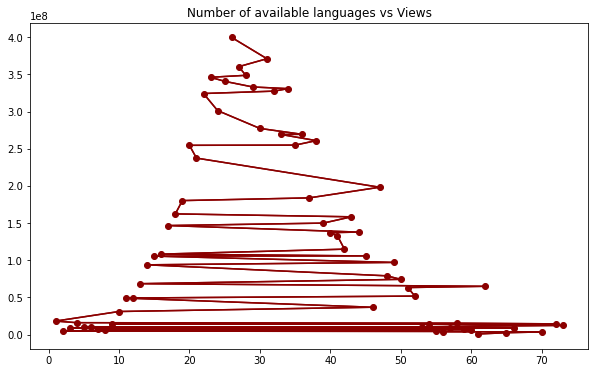

In [22]:
plt.figure(figsize=(10,6))

plt.plot(data[['available_lang','views']].groupby('available_lang').agg({'views':'sum'})['views'].sort_values(ascending=False),color='darkred')

plt.title('Number of available languages vs Views')

plt.plot(data[['available_lang','views']].groupby('available_lang').agg({'views':'sum'})['views'].sort_values(ascending=False),marker='o',color='darkred')

My hypothesis is wrong. Number of languages doesn't effect the views.

# **5. Occupation:**

In [23]:
data['occupations'][0]

"{0: ['climate advocate']}"

Convert String to dictionary and obtain the value from the list:

In [24]:
data['occupations']=data['occupations'].apply(convert_string_to_original_dtype)

In [25]:
#Function to convert list to string
def list_to_string(x):
  for item in x:
    return item

In [26]:
data['occupations'].isnull().sum()

522

In [27]:
#Function to obtain occupation 

def get_occupation(x):
  try:
    for key,value in x.items():
      return value
  except AttributeError:
    return ['Unknown']

In [28]:
data['occupations']= data['occupations'].apply(get_occupation)

In [29]:
data['occupations']=data['occupations'].apply(list_to_string)

In [30]:
data['occupations'][0]

'climate advocate'

There are 59827 words in the combination of all Occupations.


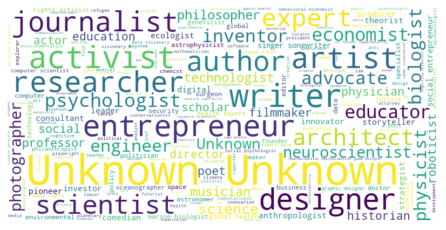

In [31]:
#Let us see some of the most commonly occuring occupations by word cloud

#making of word cloud from title column
text = " ".join(topic for topic in data.occupations.astype(str))
print ("There are {} words in the combination of all Occupations.".format(len(text)))

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

plt.axis("off")
plt.rcParams["figure.figsize"] = (10,6)
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

Entrepreneur, Activist, designer have some of the most counts. Let us see what it has to do with the views.

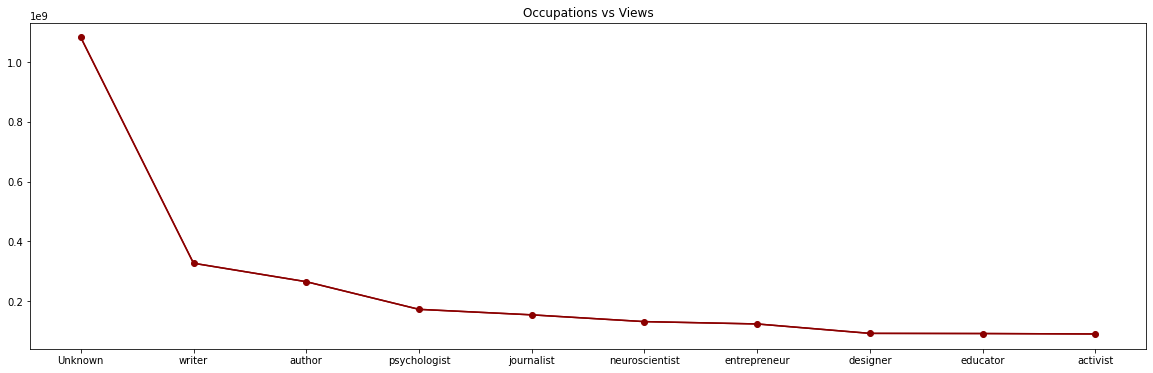

In [32]:
plt.figure(figsize=(20,6))

plt.plot(data[['occupations','views']].groupby('occupations').agg({'views':'sum'})['views'].sort_values(ascending=False).head(10),color='darkred')

plt.title('Occupations vs Views')

plt.plot(data[['occupations','views']].groupby('occupations').agg({'views':'sum'})['views'].sort_values(ascending=False).head(10),marker='o',color='darkred')

A lot of the occupations are not known but some counts like writer and author do have some good amount of views. My hypothesis cannot be rejected.

## **6.Topics:**

To determine the hidden abstract and actual topics that may or may not have been tagged I will be using the Transcript column.

### Word Preprocessing:

In [33]:
import re, string, unicodedata
import nltk
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [34]:
from keras.preprocessing.text import Tokenizer

In [35]:
#maximum number of words to keep
tokenizer = Tokenizer(nb_words="MAX_NB_WORDS")
tokenizer.fit_on_texts(data['transcript'])

Word Normalizing:

In [36]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    return words

data['transcript'] = normalize(data['transcript'])
print(data['transcript'][0])

thank you so much chris and its truly a great honor to have the opportunity to come to this stage twice im extremely grateful i have been blown away by this conference and i want to thank all of you for the many nice comments about what i had to say the other night and i say that sincerely partly because mock sob i need that laughter put yourselves in my position laughter i flew on air force two for eight years laughter now i have to take off my shoes or boots to get on an airplane laughter applause ill tell you one quick story to illustrate what thats been like for me laughter its a true story  every bit of this is true soon after tipper and i left the  mock sob white house  laughter we were driving from our home in nashville to a little farm we have 50 miles east of nashville driving ourselves laughter i know it sounds like a little thing to you but  laughter i looked in the rearview mirror and all of a sudden it just hit me there was no motorcade back there laughter youve heard of p

Topic Modelling by Geneism and Tfidf Vectorizer:

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.25,min_df=5)
doc_term_matrix = tfidf_vectorizer.fit_transform(data['transcript'].values.astype('U'))

In [39]:
#Probability matrix of the probabilities of words

from sklearn.decomposition import NMF

nmf = NMF(n_components=7, random_state=42)
nmf.fit(doc_term_matrix )

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=7, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [40]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['data', 'language', 'book', 'hes', 'computer', 'art', 'video', 'students', 'design', 'kids']


Top 10 words for topic #1:
['solar', 'stars', 'species', 'planets', 'energy', 'ocean', 'planet', 'light', 'universe', 'earth']


Top 10 words for topic #2:
['musicians', 'singing', 'piano', 'guitar', 'ends', 'song', 'play', 'musical', 'sound', 'music']


Top 10 words for topic #3:
['drugs', 'drug', 'health', 'dna', 'blood', 'disease', 'cell', 'patients', 'cancer', 'cells']


Top 10 words for topic #4:
['food', 'health', 'china', 'dollars', 'global', 'government', 'city', 'cities', 'africa', 'countries']


Top 10 words for topic #5:
['violence', 'black', 'girl', 'gender', 'womens', 'sex', 'woman', 'girls', 'men', 'women']


Top 10 words for topic #6:
['signals', 'cortex', 'stress', 'mental', 'activity', 'sleep', 'memory', 'brains', 'neurons', 'brain']




In [41]:
topic_values = nmf.transform(doc_term_matrix)
data['Topic_Cluster'] = topic_values.argmax(axis=1)

In [42]:
data['Topic_Cluster'].unique()

array([4, 0, 2, 6, 5, 1, 3])

In [43]:
# Replace the the values

replace_values={0:'Technology',1:'Science',2:'Music',3:'Health',4:'International Affairs',5:'Social Issues',6:'Mental Health'}

data['Topic_Cluster']= data['Topic_Cluster'].map(replace_values)

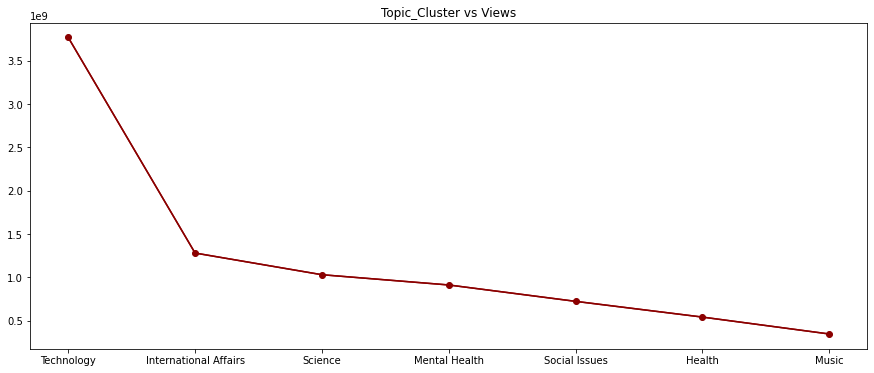

In [44]:
plt.figure(figsize=(15,6))

plt.plot(data[['Topic_Cluster','views']].groupby('Topic_Cluster').agg({'views':'sum'})['views'].sort_values(ascending=False).head(10),color='darkred')

plt.title('Topic_Cluster vs Views')

plt.plot(data[['Topic_Cluster','views']].groupby('Topic_Cluster').agg({'views':'sum'})['views'].sort_values(ascending=False).head(10),marker='o',color='darkred')

My hypothesis is correct.

## **7. Age of The Video:**

In [45]:
import datetime

In [46]:
data['published_date'] = data['published_date'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d"))

In [47]:
current_date=datetime.datetime(2021,5,22)

In [48]:
data['published_year'] = data['published_date'].apply(lambda x: x.year)

In [49]:
data['age_of_video']= current_date.year- data['published_year']

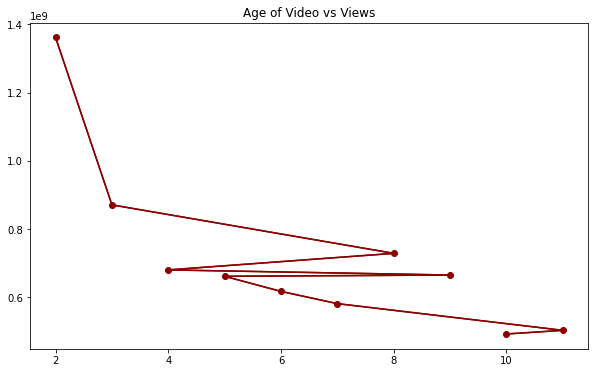

In [50]:
plt.figure(figsize=(10,6))

plt.plot(data[['age_of_video','views']].groupby('age_of_video').agg({'views':'sum'})['views'].sort_values(ascending=False).head(10),color='darkred')

plt.title('Age of Video vs Views')

plt.plot(data[['age_of_video','views']].groupby('age_of_video').agg({'views':'sum'})['views'].sort_values(ascending=False).head(10),marker='o',color='darkred')

Hypothesis can be rejected.

## **8. Comments:**

Text(0.5, 1.0, 'Comments vs Views')

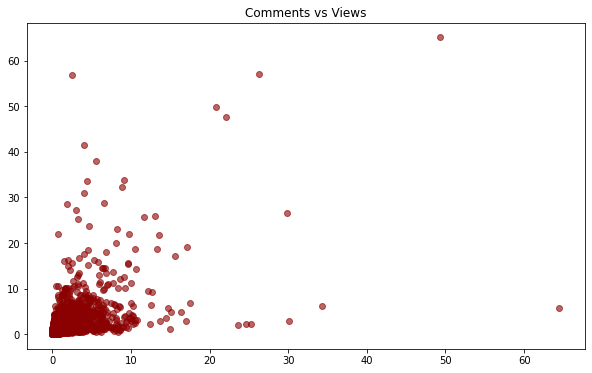

In [51]:
plt.scatter(x= data['comments']/100,y=data['views']/1000000,color='darkred',alpha=0.6)

plt.title('Comments vs Views')

Hypothesis is true except for a few outliers.

##**9. Number of Tags:**

In [52]:
#Find the number of tags

def no_of_tags(x):
  return len(x)

In [53]:
data['Num_tags']= data['topics'].apply(no_of_tags)

Text(0.5, 1.0, 'Number of tags vs Views')

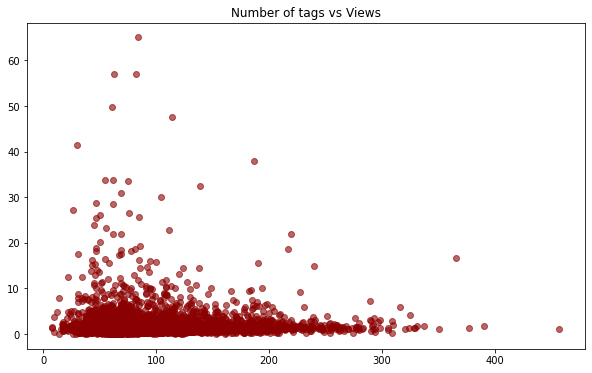

In [54]:
plt.scatter(x= data['Num_tags'],y=data['views']/1000000,color='darkred',alpha=0.6)

plt.title('Number of tags vs Views')

Hypothesis can be rejected.

# **10. Published Day:**

In [60]:
data['published_day'] = data['published_date'].apply(lambda x: x.weekday())

In [64]:
#encoding of release_day column with corresponding week day name
week_day={0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
data['published_day']=data['published_day'].map(week_day)

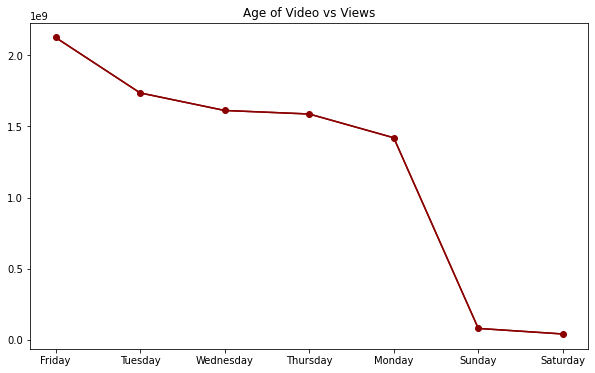

In [65]:
plt.figure(figsize=(10,6))

plt.plot(data[['published_day','views']].groupby('published_day').agg({'views':'sum'})['views'].sort_values(ascending=False).head(10),color='darkred')

plt.title('Age of Video vs Views')

plt.plot(data[['published_day','views']].groupby('published_day').agg({'views':'sum'})['views'].sort_values(ascending=False).head(10),marker='o',color='darkred')

Hypothesis was correct.

# **New Feature:**


##**Related Views:**

In [66]:
data['related_talks'][0]

'{243: \'New thinking on the climate crisis\', 547: \'The business logic of sustainability\', 2093: \'The state of the climate — and what we might do about it\', 54715: \'How we can turn the tide on climate\', 29968: \'The most important thing you can do to fight climate change: talk about it\', 2339: "Climate change is happening. Here\'s how we adapt"}'

This feature is made by taking the keys from the related_talks column and assigning a level to it according to mean of the views.

In [67]:
#applying eval function on available_lang column
data['related_talks'] = data.apply(lambda row: eval(row['related_talks']), axis=1)

In [68]:
#defining a new feature called related_views
data['related_views'] = 0
#iterating through the each row and extracting the value of related_talks
for index, row in data.iterrows():
    id_list=list(row['related_talks'].keys())
    temp=0
    for i in range(len(data)):
      if (data.loc[i,'talk_id']) in id_list:
        temp+=data.loc[i,'views']

    data.loc[index,'related_views']=temp//6

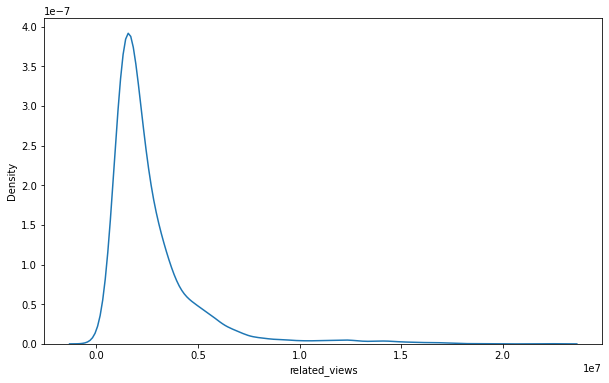

In [69]:
#Plotting the distribution

sns.kdeplot(x=data['related_views'])

It is a normally distributed curve with right skew.

# **Data Cleaning:**

In [70]:
data.columns

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description', 'transcript', 'event_category',
       'Topic_Cluster', 'published_year', 'age_of_video', 'Num_tags',
       'published_day', 'related_views'],
      dtype='object')

Columns to drop:

talk_id,title,all_speakers,about_speakers,recorded_date,published_date,native_lang,available_lang,topics, url,description,transcript,published_year,age_of_video,Num_tags,event,related_talks



In [71]:
data.drop(columns=['talk_id','all_speakers','about_speakers','recorded_date','published_date','native_lang','available_lang',
                   'topics','url','description','transcript','published_year','age_of_video','Num_tags','title','related_talks','event'],inplace= True)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   speaker_1       4005 non-null   object 
 1   occupations     4005 non-null   object 
 2   views           4005 non-null   int64  
 3   comments        3350 non-null   float64
 4   duration        4005 non-null   int64  
 5   event_category  4005 non-null   object 
 6   Topic_Cluster   4005 non-null   object 
 7   published_day   4005 non-null   object 
 8   related_views   4005 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 281.7+ KB


## Outlier Treatment:

Outlier treatment is done as this might effect the error scores later while model building.

In [73]:
#checking the outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()

Topic_Cluster       0
comments          261
duration           21
event_category      0
occupations         0
published_day       0
related_views     300
speaker_1           0
views             393
dtype: int64

In [74]:
# Replacing outliers with extreme values
for i in ['comments','duration','related_views','views']:
  Q1 = data[i].quantile(0.25)
  Q3 = data[i].quantile(0.75)
  IQR = Q3 - Q1

  data[i]=np.where(data[i]<(Q1 - 1.5 * IQR),(Q1 - 1.5 * IQR),np.where(data[i]>(Q3 + 1.5 * IQR),(Q3 + 1.5 * IQR),data[i]))

## Nan value imputation-- KNN Nan value imputer

Before imputing nan values numeircal features need to be scaled.

In [75]:
from sklearn.preprocessing import StandardScaler

In [76]:
numeric=['comments','duration']

In [77]:
scaler = StandardScaler()
scaler.fit(data[numeric])
data[numeric] = scaler.transform(data[numeric])

In [78]:
#Import libraries
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer()

#fitting the model
imputer.fit(data[numeric])

# transform the dataset
data[numeric] = imputer.transform(data[numeric])

In [79]:
data.head(1)

,speaker_1,occupations,views,comments,duration,event_category,Topic_Cluster,published_day,related_views
0,Al Gore,climate advocate,3523392.0,1.148518,0.75847,TED2000s,International Affairs,Tuesday,1659584.0


In [80]:
# for inverse transformation
data[numeric] = scaler.inverse_transform(data[numeric])


In [81]:
data.head(1)

,speaker_1,occupations,views,comments,duration,event_category,Topic_Cluster,published_day,related_views
0,Al Gore,climate advocate,3523392.0,272.0,977.0,TED2000s,International Affairs,Tuesday,1659584.0


In [82]:
data[numeric].isnull().sum()

comments    0
duration    0
dtype: int64

Nan values have been removed.

#**Feature Engineering:**

## Target Encoding categorical features:

In [86]:
data_t= data.copy()

In [87]:
data.columns

Index(['speaker_1', 'occupations', 'views', 'comments', 'duration',
       'event_category', 'Topic_Cluster', 'published_day', 'related_views'],
      dtype='object')

In [88]:
categorical_features= ['speaker_1','occupations','event_category','Topic_Cluster','published_day']

In [89]:
for column in categorical_features:
  data[column] = data[column].map(data.groupby(column)['views'].mean())

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   speaker_1       4005 non-null   float64
 1   occupations     4005 non-null   float64
 2   views           4005 non-null   float64
 3   comments        4005 non-null   float64
 4   duration        4005 non-null   float64
 5   event_category  4005 non-null   float64
 6   Topic_Cluster   4005 non-null   float64
 7   published_day   4005 non-null   float64
 8   related_views   4005 non-null   float64
dtypes: float64(9)
memory usage: 281.7 KB


#**Feature Selection:**

Selecting the best features by f_regression:

In [98]:
X= data.drop(columns='views')

Y= data['views']

In [99]:
from sklearn.feature_selection import f_regression

In [100]:
f_scores = f_regression(X,Y)
f_scores

(array([22250.64244599,  2688.25675317,   878.25383542,    36.39200856,
          119.77448366,   150.03442735,    76.6739069 ,   634.24115403]),
 array([0.00000000e+000, 0.00000000e+000, 1.12683294e-174, 1.75975910e-009,
        1.73139653e-027, 6.84082729e-034, 2.92509550e-018, 4.87581533e-130]))

In [101]:
#The second array consists of p-values that we need

p_series= pd.Series(f_scores[1],index= X.columns)

Text(0.5, 1.0, 'P-values for numerical features')

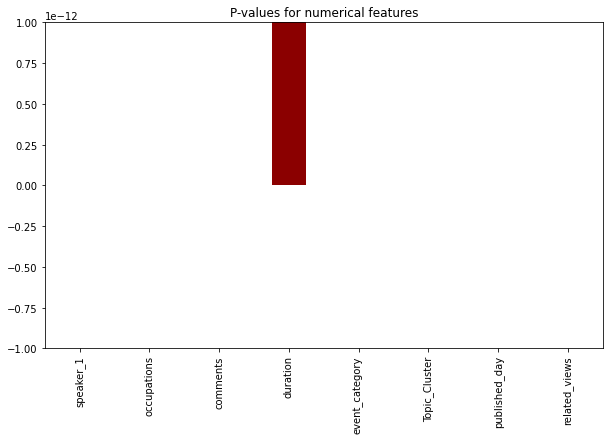

In [102]:
p_series.plot(kind='bar',color='darkred')

plt.title('P-values for numerical features')

We can drop duration column.

In [103]:
X.drop(columns='duration',inplace= True)


#**Model Selection:**

Directly moving to Tree based non-parametric algorithm as:

1. Linear relationship not required

2. Faster and easily interpretable.

In [104]:
from xgboost import XGBRegressor

In [105]:
from sklearn.model_selection import RandomizedSearchCV

In [106]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [107]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)

In [108]:
#XGBoost Regressor

# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]


#Learning rate
learning_rate=[0.01,0.05,0.1]

#L2 Regularization
reg_lambda=[0.1,0.5,1]

#L1 Regularization
reg_alpha= [0,0.01]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Dict
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'learning_rate':learning_rate,
              'reg_alpha':reg_alpha,
              'reg_lambda':reg_lambda}

# Create an instance of the XGBoost
xgb_model = XGBRegressor()

#RandomSearch
xgb_random = RandomizedSearchCV(xgb_model,param_dict,verbose=2,cv=5)


xgb_random.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] reg_lambda=0.5, reg_alpha=0.01, n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=6, learning_rate=0.1 
[14:58:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg_lambda=0.5, reg_alpha=0.01, n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=6, learning_rate=0.1, total=   0.3s
[CV] reg_lambda=0.5, reg_alpha=0.01, n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=6, learning_rate=0.1 
[14:58:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  reg_lambda=0.5, reg_alpha=0.01, n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=6, learning_rate=0.1, total=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] reg_lambda=0.5, reg_alpha=0.01, n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=6, learning_rate=0.1 
[14:58:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  reg_lambda=0.5, reg_alpha=0.01, n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=6, learning_rate=0.1, total=   0.2s
[CV] reg_lambda=0.5, reg_alpha=0.01, n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=6, learning_rate=0.1 
[14:58:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  reg_lambda=0.5, reg_alpha=0.01, n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=6, learning_rate=0.1, total=   0.2s
[CV] reg_lambda=0.5, reg_alpha=0.01, n_estimators=80, min_samples_split=150, min_samples_leaf=50, max_depth=6, learning_rate=0.1 
[14:58:28] WARNING: /workspace/src/objective/regression_obj.cu:152

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.8s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                          verbosity=1),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [0.01, 0.05, 0

In [109]:
#Building optimal model on the best estimators
xgb_optimal_model = xgb_random.best_estimator_

In [110]:
# make predictions for test data
y_hat = xgb_optimal_model.predict(X_test)

In [111]:
print(f'r_sqr value for train: {xgb_optimal_model.score(X_train, y_train)}')

r_sqr value for train: 0.885040095340418


In [112]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [113]:
r_squared= r2_score(y_test,y_hat)

In [114]:
#Calculate Adjusted R-sqaured
adjusted_r_squared = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print(f'The R_Squared for XGBoost is {r_squared} for train and adjusted R_Squared is {adjusted_r_squared}')


The R_Squared for XGBoost is 0.8302561144504037 for train and adjusted R_Squared is 0.8299588396946251


In [115]:
import math

In [116]:
print(f'The Root Mean Squared Error for XGBoost is: {math.sqrt(mean_squared_error(y_test,y_hat))}')

The Root Mean Squared Error for XGBoost is: 457961.94798753655


In [117]:
print(f'The mean absolute error for XGBoost is: {mean_absolute_error(y_test,y_hat)}')

The mean absolute error for XGBoost is: 228800.00183227294


In [120]:
print(f'The error percentage for XGboost is : {round((mean_absolute_error(y_test,y_hat)/Y.mean()*100),2)}% of views')

The error percentage for XGboost is : 13.77% of views
